# CLASSIFYING AMAZON FOOD REVIEWS USING SUPPORT VECTOR MACHINES

In [71]:
# Importing the libraries required for our task

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [72]:
# Importing the required sqlite database which contains the reviews

con = sqlite3.connect('database.sqlite')

'''
Our objective is to check whether the review is positive or negative.

The dataset originally consists of reviews from 1 to 5. We will consider reviews which are rated as 4 and 5 to be positive, reviews 
which are rated 1 and 2 to be negative. As, we cannot draw any conclusions from review which is rated 3 star we will eliminate
all the reviews rated 3 star.

'''

# Filtering out the data w/o the 3 star reviews

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

In [73]:
# Checking whether the data has been filtered properly

filtered_data['Score'].unique()

# We can see that there is no 3 star review in the data

array([5, 1, 4, 2], dtype=int64)

In [74]:
# As we have eliminated the data with 3 start reviews, we will label the remaining data(4 and 5 scores) as positive and negative(1 and 2 scores).

# Creating a function to label the data
def partition(x):
    if x < 3:
        return '0'
    return '1'


# Applying the labels to the data

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [75]:
# Checking the first few rows of the data

filtered_data.head(10)

# We can see that the score has been changed to positive and negative instead of 5,4,1,2

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [76]:
# Let us look at the shape of the data

filtered_data.shape

(525814, 10)

In [77]:
# Dropping any duplicates if they are present in the data

duplicates_dropped=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
duplicates_dropped.shape

(364173, 10)

In [78]:
# Eliminating the rows where helpfulness numerator is greator than the helfulness denominator

final=duplicates_dropped[duplicates_dropped.HelpfulnessNumerator<=duplicates_dropped.HelpfulnessDenominator]

In [79]:
# Taking a look at the shape of the data

final.shape

(364171, 10)

In [80]:
# We will select only the required columns of which we will filter some reviews and assign them their labels and sort them wrt time

final_data = final[['ProductId','Time','Text','Score']]

In [81]:
# Checking the dimension of the data
final_data.shape


(364171, 4)

In [82]:
# Randomly selecting some reviews from the 'final_data' data

# First we will extract the values from the given dataframe

X=final_data.iloc[:,:].values

# randomly extracting 15000 reviews from the dataset

import random

n = 364171
m = 30000
p = m/n

sampled_data = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_data.append(X[i,:])

In [83]:
# Assigning the extracted data to a dataframe

names = ['ProductId','Time','Text','Score']

sample = pd.DataFrame(sampled_data,columns= names)

In [84]:
# Checking the dimensions of the sampled data

sample.shape

(29889, 4)

In [85]:
# Checking the first few rows of the data

sample.head()

,ProductId,Time,Text,Score
0,B006K2ZZ7K,1340150400,This saltwater taffy had great flavors and was...,1
1,B001GVISJM,1348099200,I love eating them and they are good for watch...,0
2,B001GVISJM,1304467200,I love this candy. After weight watchers I ha...,1
3,B001EO5QW8,1350777600,I WAS VISITING MY FRIEND NATE THE OTHER MORNIN...,1
4,B004N5KULM,1320105600,"Halloween is over but, I sent a bag to my daug...",1


In [86]:
# Now we will sort the data according to timestamp

sorted_data=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [87]:
# Checking if the data has been sorted or not

sorted_data.head(15)

,ProductId,Time,Text,Score
102,B00002Z754,962236800,I just received my shipment and could hardly w...,1
13809,B00004RYGX,1014163200,Just hilarious... my favorite part is the dini...,1
13808,B00004RYGX,1015718400,Beetlejuice is not a movie that you can't watc...,1
13816,B00004RYGX,1023235200,What can I say? This is a CLASSIC! I've seen t...,1
9606,0006641040,1025481600,"My daughter loves all the ""Really Rosie"" books...",1
22913,B0000D9N9A,1068422400,Put in under a Reclette grill or just put it i...,1
16362,B0000DCXFY,1069027200,While Pesto Genovese is my favorite pesto for ...,1
27246,B0000D94P1,1069113600,I have relied on these cake mixes for a few ye...,1
17902,B0000DIVUR,1070755200,My brother-in-law was thrilled with this gift ...,1
6738,B0000UD67Y,1072656000,I've tried many of packaged Chai products - li...,1


In [88]:
# We can see that the data has been sorted wrt time, now we will only consider the 'Text' and 'Score' columns henceforth

sorted_final = sorted_data[['Text','Score']]


In [89]:
# Checking the first few rows of the data to ensure we have the right data

sorted_final.head()

,Text,Score
102,I just received my shipment and could hardly w...,1
13809,Just hilarious... my favorite part is the dini...,1
13808,Beetlejuice is not a movie that you can't watc...,1
13816,What can I say? This is a CLASSIC! I've seen t...,1
9606,"My daughter loves all the ""Really Rosie"" books...",1


In [90]:
# The next task is to clean the text data so that it can be fed to the model

# Checking if there are unknown elements in the data

# find sentences containing HTML tags

import re

i=0;
for sent in sorted_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   
    
# We can see that the data contains html tags, we will need to remove those

3
What can I say? This is a CLASSIC! I've seen this movie so many times I actually have most of the words memorized. This movie is hilariously funny, but at the same time it has a touch of drama in it. It's an all around great movie.<p>Michael Keaton does an excellent job of playing the odd, funny, and perverted Beetlejuice who causes quite the chaos with a newly deceased couple, Adam and Barbara. Let me just say no one and I mean NO ONE could've been better for the part of Beetlejuice.<p>The only disapointting thing about the DVD Beetljuice is there were no deleted scenes or extra footage.. I was disapointed, but I love this movie so much it was still worth it!<p>If you haven't seen Beetlejuice, then YOU MUST SEE IT. And for all the Beetlejuice lovers and fans out there this is a must have to your video or DVD collection~


In [91]:
'''
We will perform the data cleaning steps on the text data.
For that we will import some packages for stopwords removal, word stemmatization and cleaning html and punctuation marks.
'''
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kulkarni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [93]:
sorted_final['Cleaned_Text'] = final_string

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Using the W2Vec representation of the text data to apply the SGD Classifier

In [94]:
# Importing the required models for the project

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [95]:
import gensim
i=0
list_of_sent=[]
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [96]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [97]:
words = list(w2v_model.wv.vocab)
print(len(words))

10889


# Creating an Avg W2Vec representation of each review

In [98]:


# Computing the Avg W2Vec representation of each review and storing it in 'sent_vectors' list

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

29889
50


In [99]:
# Storing the list in a variable 'X2'

X2 = sent_vectors

In [100]:
# Storing the review score in a 'y2' variable

y2 = sorted_final['Score']

In [101]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3) # Splitting train test with 70:30 ratio

In [102]:
# Splitting the train data into train and cross validation sets

X_tr2, X_CV2, y_tr2, y_CV2 = train_test_split(X_train2, y_train2, test_size=0.3) # Splitting train cross-val with 70:30 ratio

In [103]:
# Importing the libraries required for decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depth = [2,3,5,7,10]
scores = []

for i in depth:
    dtree_clf = DecisionTreeClassifier(max_depth = i)
    dtree_clf.fit(X_tr2, y_tr2)
    pred = dtree_clf.predict(X_CV2)
    
    # evaluate CV accuracy
    acc = accuracy_score(y_CV2, pred, normalize=True) # * float(100)
    scores.append(acc)


The optimal depth is 2.


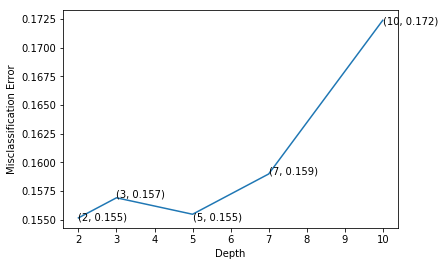

the misclassification error for each depth value is :  [0.155 0.157 0.155 0.159 0.172]


In [104]:
# Calculating the miss-classification error
MissClErr = [1-x for x in scores]

# determining the best depth
optimal_depth = depth[MissClErr.index(min(MissClErr))]
print('\nThe optimal depth is %d.' % optimal_depth)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(depth,MissClErr)

for xy in zip(depth, np.round(MissClErr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MissClErr,3))


# We can see that for depth value of 2 we get minimum miss classification error validation error 

# Creating a Decision Tree Classifier model with avgW2Vec text representation with a depth value of 2

In [105]:
dtree_clf = DecisionTreeClassifier(max_depth = 2)
dtree_clf.fit(X_tr2, y_tr2)
pred1 = dtree_clf.predict(X_test2)

# evaluate CV accuracy
acc1 = accuracy_score(y_test2, pred1, normalize=True) * float(100)
print('\nThe accuracy of the Decision Tree Classifier for depth = %d is %f%%' % (optimal_depth, acc1))




The accuracy of the Decision Tree Classifier for depth = 2 is 84.409502%


# Creating a Tf-Idf weighted W2Vec representation of each review

In [106]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [107]:
# Checking for any 'NaN' values in the data

np.isnan(tfidf_sent_vectors).any()

# We can see that there are na values in the data

True

In [108]:
# We will replace all the 'Nan' values w/ mean of the respective columns


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_tfidf = imp.fit_transform(tfidf_sent_vectors) # Assigning the imputed matrix w/o Nan values to data variable

In [109]:
# Checking if our imputation has succeded

np.isnan(data_tfidf).any()

# We can see that there are no na values any more.

False

In [110]:
# Assigning the 'data_tfidf' matrix to 'X3' variable

X3 = data_tfidf

In [111]:
# Assigning the scores to the 'y3' variable

y3 = sorted_final['Score']

In [112]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3) # Splitting train test with 70:30 ratio

In [113]:
# Splitting the train data into train and cross validation sets

X_tr3, X_CV3, y_tr3, y_CV3 = train_test_split(X_train3, y_train3, test_size=0.3) # Splitting train cross-val with 70:30 ratio

In [114]:
# Importing the libraries required for decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depth = [2,3,5,7,10]
scores1  = []

for i in depth:
    dtree_clf1 = DecisionTreeClassifier(max_depth = i)
    dtree_clf1.fit(X_tr3, y_tr3)
    pred_tfidf = dtree_clf1.predict(X_CV3)
    
    # evaluate CV accuracy
    acc_tfidf = accuracy_score(y_CV3, pred_tfidf, normalize=True)
    scores1.append(acc_tfidf)


The optimal depth is 5.


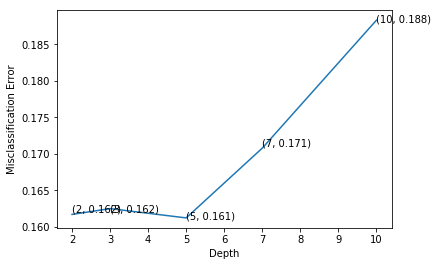

the misclassification error for each depth value is :  [0.162 0.162 0.161 0.171 0.188]


In [115]:
# Calculating the miss-classification error
MissClErr1 = [1-x for x in scores1]

# determining the best depth
optimal_depth1 = depth[MissClErr1.index(min(MissClErr1))]
print('\nThe optimal depth is %d.' % optimal_depth1)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(depth,MissClErr1)

for xy in zip(depth, np.round(MissClErr1,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MissClErr1,3))


# We can see that for depth value of 5 we get minimum miss classification error validation error

# Creating a Decision Tree Classifier model with avgW2Vec text representation with a depth value of 5

In [117]:
dtree_clftfidf = DecisionTreeClassifier(max_depth = 5)
dtree_clftfidf.fit(X_tr3, y_tr3)
pred_tfidf = dtree_clftfidf.predict(X_test3)

# evaluate CV accuracy
acc_tfidf = accuracy_score(y_test3, pred_tfidf, normalize=True) * float(100)
print('\nThe accuracy of the Decision Tree Classifier for depth = %d is %f%%' % (optimal_depth1, acc_tfidf))



The accuracy of the Decision Tree Classifier for depth = 5 is 84.732910%


# We have performed classification using Decision Tree classifier and have only considered avgw2vec and tfidfw2vec representations of the text data. BoW and TF-IDF have been eliminated to reduce the space and time complexity to train and test the data.

# We have selected the max_depth value based on the miss classification error